<a href="https://colab.research.google.com/github/AeroEng16/machine-learning-with-python-logistic-regression-3211129/blob/main/02_nnclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial link - https://youtu.be/V_xro1bcAuA
https://learnpytorch.io

## Neural Network Classification
Classification is a problem of predicting if something is one thing or another (can have multiple options)


## 1. Make Classification data and get it ready


In [40]:
from sklearn.datasets import make_circles

# Make 1000 samples

n_samples = 1000

#Create circles

X,Y = make_circles(n_samples,
                   noise = 0.03,
                   random_state = 42)

In [41]:
len(X),len(Y)

(1000, 1000)

In [42]:
# Make dataframe of circle data

import pandas as pd

circles = pd.DataFrame({"X1":X[:,0],
                       "X2":X[:,1],
                       "label":Y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


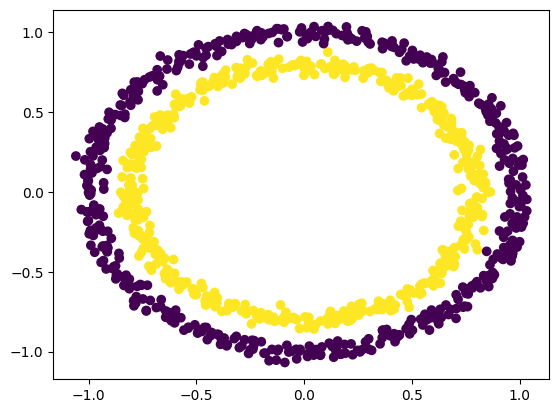

In [43]:
# Visualise

import matplotlib.pyplot as plt

plt.scatter(x = circles.X1,
            y=circles.X2,
            c=circles.label,
            )

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment with but sizeable enough to be relevant.

### 1.1 Check input and output shapes

In [44]:
X.shape,Y.shape

((1000, 2), (1000,))

In [45]:
# View the first example of features and labels

X_sample = X[0]
Y_sample = Y[0]

print(f"values for one sample of X: {X_sample} and the same for Y: {Y_sample}")
0

values for one sample of X: [0.75424625 0.23148074] and the same for Y: 1


0

### 1.2 Turn data into tensors and create train and test splits

In [46]:
# Turn data into tensors
import torch
torch.__version__

'2.0.1+cu118'

In [47]:
print(X.dtype)
X_tensor = torch.from_numpy(X).type(torch.float)
Y_tensor = torch.from_numpy(Y).type(torch.float)

float64


In [48]:
#Split data into training and test sets

from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X_tensor,
                                               Y_tensor,
                                               test_size = 0.2,     #20% for test data and 80% for train split
                                               random_state = 42)

## 2 Building a Model

We want to:

1. Setup device agnostic code
2. Construct a model (subclass nn.module)
3. Define loss function and optimiser
4. Create a training and test loop

In [49]:
# Import pytorch and nn

import torch
from torch import nn

# Make device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

Now we've setup device agnostic code lets create a model:

1. Subclass `nn.module` (almost all models in PyTorch subclass this)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model.
4. Instantiate an instance of our model class and send it to the target device

In [50]:
# 1. Construct a model that subclass nn.module

class circleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    #2. Create 2 linear layers that are capable of handling our data
    self.layer_1 = nn.Linear(in_features = 2,   #takes in 2 features and upscales to 5 features
                             out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5,   # take in 5 features from previous layer and outputs a single feature (same shape as Y)
                             out_features = 1)
  # 3. Define a forward method that outlines the forward pass
  def forward(self,x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send to target device

model_0 = circleModelV0().to(device)

In [51]:
model_0

circleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [52]:
# lets replicate the model above using nn.Sequential()

model_0_Sequential = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1),
)
model_0_Sequential.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [53]:
model_0_Sequential

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [54]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5520,  0.6799],
                      [-0.3445, -0.5158],
                      [ 0.5673,  0.5541],
                      [-0.5399, -0.0547],
                      [-0.6973, -0.5788]])),
             ('layer_1.bias',
              tensor([ 0.1366,  0.1881,  0.1499, -0.1924,  0.6524])),
             ('layer_2.weight',
              tensor([[ 0.0639, -0.2639, -0.0253,  0.1074,  0.1566]])),
             ('layer_2.bias', tensor([-0.3162]))])

In [55]:
# Make Predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"First 10 predictions:\n {untrained_preds[:10]}")
print(f"First 10 labels:\n {Y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
First 10 predictions:
 tensor([[-0.2115],
        [-0.2140],
        [-0.2623],
        [-0.1969],
        [-0.3530],
        [-0.3539],
        [-0.2888],
        [-0.3218],
        [-0.2583],
        [-0.2152]])
First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimiser

Which loss function of optimiser should you use?

This is problem specific. For example, for regression you might want MAE or MSE (mean absolute or mean squared error). For classification you might want binary cross entropy or categorical cross entropy (sometimes just referred to as cross entropy).

And for optimiser, two of the most common are SGD and Adam, however PyTorch has many built in options.

* For the loss function we're going to user `torch.nn.BCEWithLogitsLoss()`

* For a definition on what a logit is in deep learning.

*Summary

In context of deep learning the logits layer means the layer that feeds in to softmax (or other such normalization). The output of the softmax are the probabilities for the classification task and its input is logits layer. The logits layer typically produces values from -infinity to +infinity and the softmax layer transforms it to values from 0 to 1.*

In [56]:
# Setup loss function

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss has sigmoid activiation function built in

optimizer= torch.optim.SGD(params = model_0.parameters(),
                           lr = 0.1)

In [57]:
# Calculate accuracy -  out of x examples, how many time does out model get it right?

def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc


## 3. train model

To build a training loop, compute the following steps:

1. Forward pass
2. Calculate loss
3. Optimiser zero grad
4. Back propagation
5. Optimiser step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function e.g. sigmoid for binary cross entropy or softmax for multi-class classification.

Then we can convert our models prediction probabilities to prediction labels by either rounding (binary) or taking argmax (multi-class).

In [58]:
# View the first five outputs of the forward pass of the test data
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2115],
        [-0.2140],
        [-0.2623],
        [-0.1969],
        [-0.3530]])

In [59]:
# Use the sigmoid activation function on our model logits (to turn model logits into prediction probabilities)

y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.4473],
        [0.4467],
        [0.4348],
        [0.4509],
        [0.4126]])

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y=1`
* `y_preds_probs` <0.5, `y=01`

In [60]:
# Find the predicted labels from the prediction probabilities.

y_preds = torch.round(y_preds_probs)

# In full (logits -> pred probs -> pred labels)

y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))


# Check for equality between all in one line or multiple lines for same outcome

print(torch.eq(y_preds.squeeze(),y_preds_labels.squeeze()))





tensor([True, True, True, True, True])


### 3.2 Building a training and test loop



In [61]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, Y_train = X_train.to(device),Y_train.to(device)
X_test, Y_test = X_test.to(device),Y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 Y_train)
  acc = accuracy_fn(Y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()

    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        Y_test)
    test_acc = accuracy_fn(y_true = Y_test,
                      y_pred = test_pred)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}, Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")



Epoch: 0, Loss: 0.70311, Acc: 50.00, Test Loss: 0.70303, Test Acc: 50.00
Epoch: 10, Loss: 0.69763, Acc: 50.00, Test Loss: 0.69786, Test Acc: 50.00
Epoch: 20, Loss: 0.69520, Acc: 50.00, Test Loss: 0.69568, Test Acc: 50.00
Epoch: 30, Loss: 0.69411, Acc: 49.25, Test Loss: 0.69483, Test Acc: 48.00
Epoch: 40, Loss: 0.69361, Acc: 46.75, Test Loss: 0.69456, Test Acc: 42.00
Epoch: 50, Loss: 0.69336, Acc: 48.62, Test Loss: 0.69453, Test Acc: 47.00
Epoch: 60, Loss: 0.69324, Acc: 48.75, Test Loss: 0.69459, Test Acc: 50.00
Epoch: 70, Loss: 0.69318, Acc: 49.25, Test Loss: 0.69468, Test Acc: 49.00
Epoch: 80, Loss: 0.69314, Acc: 49.75, Test Loss: 0.69478, Test Acc: 49.00
Epoch: 90, Loss: 0.69312, Acc: 50.00, Test Loss: 0.69486, Test Acc: 48.00
Epoch: 100, Loss: 0.69310, Acc: 50.25, Test Loss: 0.69492, Test Acc: 47.00
Epoch: 110, Loss: 0.69309, Acc: 50.50, Test Loss: 0.69498, Test Acc: 47.50
Epoch: 120, Loss: 0.69308, Acc: 50.12, Test Loss: 0.69501, Test Acc: 47.00
Epoch: 130, Loss: 0.69307, Acc: 50.8

## 4. Make Predictions and evaluate the model

From the metrics it looks like our model isn't learning.

To inspect the data make some predictions with the training model.

To do so, wer're going to import a function called plot_decision_boundary https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [62]:
import requests
from pathlib import Path

# Download helper function from pyTorch repo if not already downloaded

if Path("helper_functions.py").is_file():
  pass
else:
  print("Downloading helper functions")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

  from helper_functions import plot_predictions, plot_decision_boundary

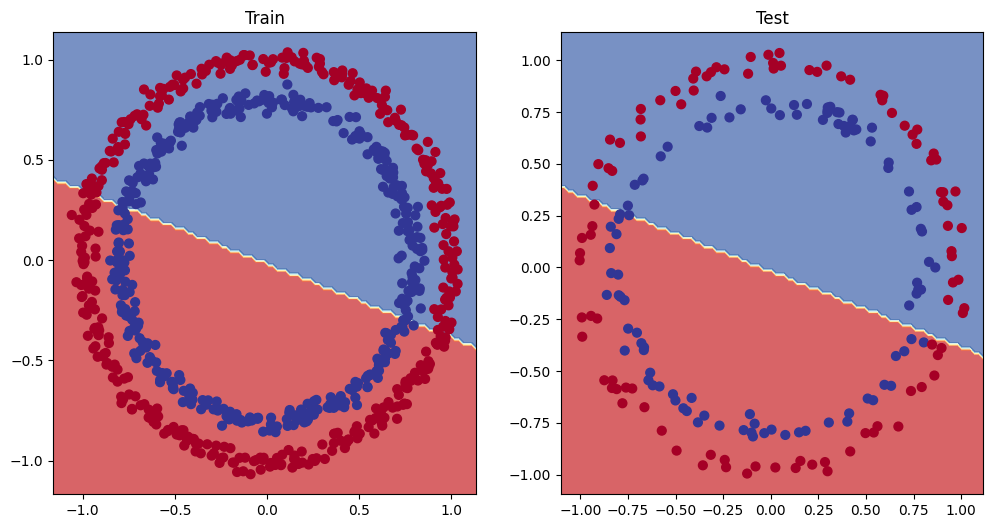

In [63]:
# Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,Y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,Y_test)

## 5. Improving a Model (from a model perspective)

* Add more layers - give the model more chance to learn about patterns
* Add more hidden units = go from 5 hidden units to 10
* Fit for longer - more epochs
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from our models perspective because they deal directly with the model, rather than our data.

Each of the list above is referred to as **hyperparameters**.

Lets try and improve the model by:

* Adding more hidden units
* Increase the number of layers
* Increase the number of epochs



In [64]:
class circleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))  #this way of writing operations rather than line by line leverages speed ups where possible behind the scenes

model_1 = circleModelV1().to(device)
model_1

circleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [65]:
# Create a loss function

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss has sigmoid activiation function built in

# Create an optimiser

optimizer_1= torch.optim.SGD(params = model_1.parameters(),
                           lr = 0.1)



In [66]:
# Create a training and evaluation loop

epochs = 1000

for epoch in range(epochs):

  #0. Set to train
  model_1.train()

  #1. Run forward loop

  y_logits = model_1(X_train).squeeze()

  y_pred = torch.round(torch.sigmoid(y_logits))

  #2. Calculate loss
  loss = loss_fn(y_logits,
                 Y_train)
  acc = accuracy_fn(Y_train,
                    y_pred=y_pred)


  #3. Zero grad

  optimizer_1.zero_grad()

  #4. Back propagate loss

  loss.backward()

  #5. Optimize step

  optimizer_1.step()

  #6. Evaluate

  model_1.eval()
  with torch.inference_mode():
    Y_logit_test = model_1(X_test).squeeze()
    Y_preds_test = torch.round(torch.sigmoid(Y_logit_test))
    test_loss = loss_fn(Y_logit_test,Y_test)
    acc_test = accuracy_fn(Y_test,y_pred=Y_preds_test)
    if epoch %100 == 0:
        print(f"epoch: {epoch}, Loss: {loss}, acc: {acc}, Test loss: {test_loss}, test acc: {acc_test}")



epoch: 0, Loss: 0.6939550638198853, acc: 50.875, Test loss: 0.6926146745681763, test acc: 51.0
epoch: 100, Loss: 0.6930477619171143, acc: 50.375, Test loss: 0.6937903761863708, test acc: 48.0
epoch: 200, Loss: 0.692986011505127, acc: 51.125, Test loss: 0.6943727135658264, test acc: 46.0
epoch: 300, Loss: 0.6929805278778076, acc: 51.625, Test loss: 0.6945767998695374, test acc: 45.0
epoch: 400, Loss: 0.6929798722267151, acc: 51.125, Test loss: 0.6946452260017395, test acc: 46.0
epoch: 500, Loss: 0.6929798722267151, acc: 51.0, Test loss: 0.6946679949760437, test acc: 46.0
epoch: 600, Loss: 0.6929798722267151, acc: 51.0, Test loss: 0.694675624370575, test acc: 46.0
epoch: 700, Loss: 0.6929798722267151, acc: 51.0, Test loss: 0.6946781873703003, test acc: 46.0
epoch: 800, Loss: 0.6929798722267151, acc: 51.0, Test loss: 0.6946792006492615, test acc: 46.0
epoch: 900, Loss: 0.6929798126220703, acc: 51.0, Test loss: 0.694679319858551, test acc: 46.0


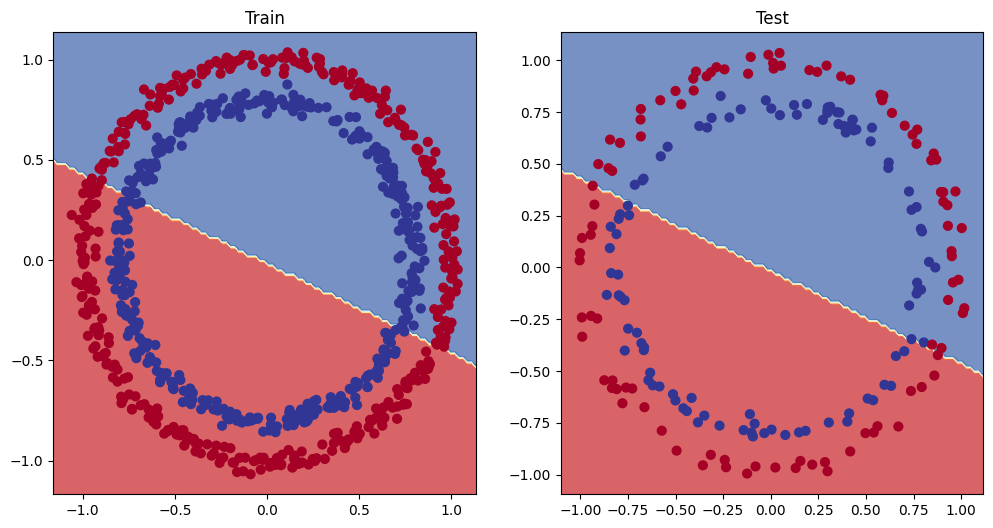

In [67]:
# Plot decision boundary

# Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,Y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,Y_test)

### 5.1 Preparing data to see if our model can learn anything

One way to test a larger problem is to use a smaller problem

In [68]:
# Create some data (linear data)

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01
#Create data
X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
Y_regression = weight*X_regression+bias

#Split data into training and test sets

from sklearn.model_selection import train_test_split

X_train_regression,X_test_regression,Y_train_regression,Y_test_regression=train_test_split(X_regression,
                                               Y_regression,
                                               test_size = 0.2,     #20% for test data and 80% for train split
                                               random_state = 42)

len(X_train_regression),len(X_test_regression),len(Y_train_regression),len(Y_test_regression)


(80, 20, 80, 20)

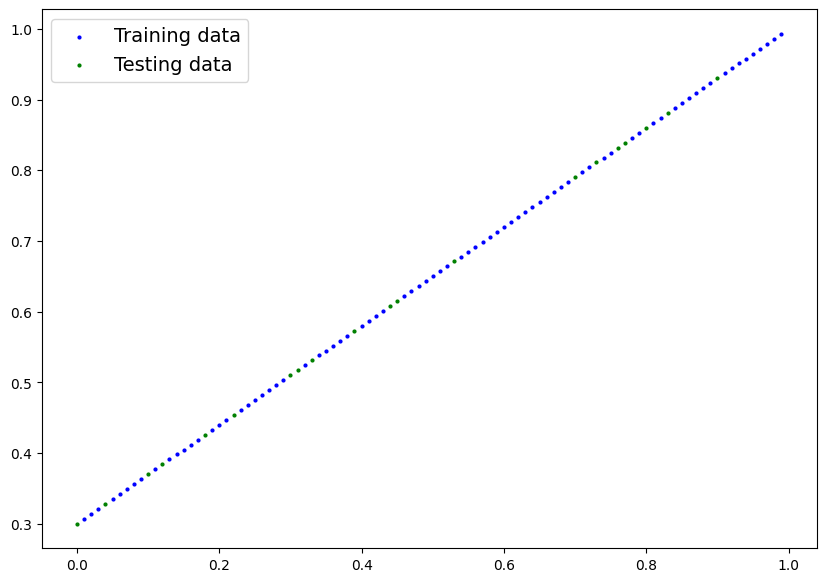

In [69]:
# plot data

from helper_functions import plot_predictions

plot_predictions(train_data =X_train_regression,
                 train_labels = Y_train_regression,
                 test_data = X_test_regression,
                 test_labels = Y_test_regression)

In [70]:
class circleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 1, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))  #this way of writing operations rather than line by line leverages speed ups where possible behind the scenes

model_1_regression = circleModelV2().to(device)
model_1_regression

circleModelV2(
  (layer_1): Linear(in_features=1, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [71]:
# Setup new optimiser
loss_fn = nn.L1Loss()

optimiser_regression = torch.optim.SGD(params = model_1_regression.parameters(),
                                       lr = 0.01)
#train and test

epochs = 1000
X_train_regression = X_train_regression.to(device)
Y_train_regression = Y_train_regression.to(device)
X_test_regression = X_test_regression.to(device)
Y_test_regression = Y_test_regression.to(device)

for epoch in range (epochs):
  model_1_regression.train()
  #1. Forward pass
  y_preds = model_1_regression(X_train_regression).squeeze()
  #y_preds = torch.round(torch.sigmoid(y_logits))
  #2 Loss Functions
  loss = loss_fn(y_preds,Y_train_regression.squeeze())
  acc = accuracy_fn(y_true = Y_train_regression, y_pred = y_preds)

  #3. zero grad
  optimiser_regression.zero_grad()
  #4. back propagate
  loss.backward()
  #5. Optimiser step
  optimiser_regression.step()
  #6. Evaluate
  model_1_regression.eval()
  with torch.inference_mode():
    test_preds = model_1_regression(X_test_regression).squeeze()
    #test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_preds,Y_test_regression.squeeze())

    test_acc = accuracy_fn(y_true = Y_test_regression, y_pred = test_preds)

    if epoch%100 == 0:
        print(f"epoch: {epoch}, Loss: {loss}, acc: {acc}, Test loss: {test_loss}, test acc: {test_acc}")


epoch: 0, Loss: 0.6423797607421875, acc: 0.0, Test loss: 0.5718773603439331, test acc: 0.0
epoch: 100, Loss: 0.03937768191099167, acc: 0.0, Test loss: 0.016179773956537247, test acc: 0.0
epoch: 200, Loss: 0.041021909564733505, acc: 0.0, Test loss: 0.01356411911547184, test acc: 0.0
epoch: 300, Loss: 0.03663818538188934, acc: 0.0, Test loss: 0.017039360478520393, test acc: 0.0
epoch: 400, Loss: 0.03273596242070198, acc: 0.0, Test loss: 0.020109694451093674, test acc: 0.0
epoch: 500, Loss: 0.030544305220246315, acc: 0.0, Test loss: 0.02148246020078659, test acc: 0.0
epoch: 600, Loss: 0.029051821678876877, acc: 0.0, Test loss: 0.02202570252120495, test acc: 0.0
epoch: 700, Loss: 0.028621012344956398, acc: 0.0, Test loss: 0.021546369418501854, test acc: 0.0
epoch: 800, Loss: 0.030382758006453514, acc: 0.0, Test loss: 0.01895572617650032, test acc: 0.0
epoch: 900, Loss: 0.03015695884823799, acc: 0.0, Test loss: 0.018370216712355614, test acc: 0.0


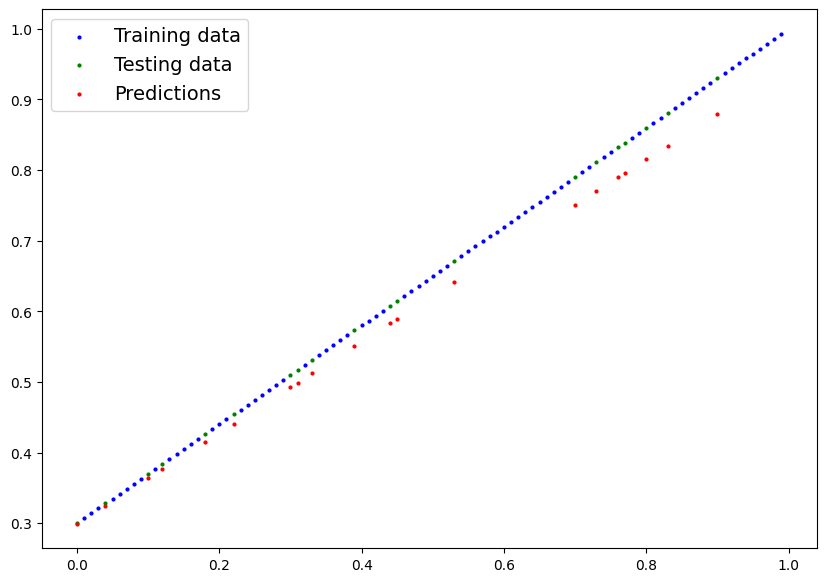

In [72]:
plot_predictions(train_data =X_train_regression.cpu(),
                 train_labels = Y_train_regression.cpu(),
                 test_data = X_test_regression.cpu(),
                 test_labels = Y_test_regression.cpu(),
                 predictions = test_preds.cpu())

## 6. The missing piece: Non-linearity



### 6.1 Recreating non-linear data (red and blue circles)

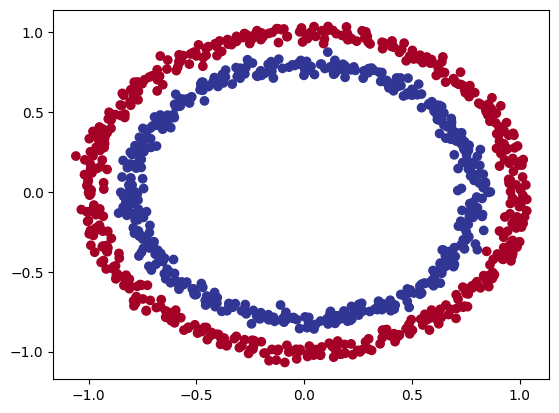

In [73]:
# Make and plot data

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
n_samples = 1000

X,Y = make_circles(n_samples,noise = 0.03, random_state = 42)

plt.scatter(X[:,0],X[:,1],c=Y, cmap = plt.cm.RdYlBu)

In [74]:
# Convert data to tensors and train/test splits

import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors

X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)

# train/test split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

len(Y_train),len(Y_test),len(X_train),len(X_test)

(800, 200, 800, 200)

### 6.2 Building a model with non-linearity

In [75]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features  = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features  = 1)
    self.relu = nn.ReLU()

  def forward(self,x):
    # where do the non-linear activation functions go?

    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [76]:
model_3 = CircleModelV2()
model_3.to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [77]:
# Loss function and optimiser

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss has sigmoid activiation function built in


optimiser_nonLinear = torch.optim.SGD(params = model_3.parameters(),
                                      lr = 0.1)

# test and training loop

epochs = 4500

X_train,Y_train = X_train.to(device),Y_train.to(device)
X_test,Y_test = X_test.to(device),Y_test.to(device)

for epoch in range(epochs):
  model_3.train()
  #1.Forward pass
  Y_logits = model_3(X_train).squeeze()
  Y_preds = torch.round(torch.sigmoid(Y_logits))
  #2.Calc loss
  loss = loss_fn(Y_logits,Y_train)
  acc = accuracy_fn(y_true=Y_train,y_pred = Y_preds)
  #3. Zero grad
  optimiser_nonLinear.zero_grad()
  #4. backpropagation
  loss.backward()
  #5. Optimiser step
  optimiser_nonLinear.step()
  #6. Evaluation
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,Y_test)
    test_acc = accuracy_fn(y_true=Y_test,y_pred=test_preds)
  if epoch %100 == 0:
      print(f"epoch: {epoch}, Loss: {loss}, acc: {acc}, Test loss: {test_loss}, test acc: {test_acc}")


epoch: 0, Loss: 0.6928354501724243, acc: 52.625, Test loss: 0.69166100025177, test acc: 52.0
epoch: 100, Loss: 0.6897448897361755, acc: 52.37500000000001, Test loss: 0.6886698007583618, test acc: 52.0
epoch: 200, Loss: 0.6873188614845276, acc: 56.375, Test loss: 0.6864684820175171, test acc: 55.50000000000001
epoch: 300, Loss: 0.6838830709457397, acc: 56.75, Test loss: 0.6831088066101074, test acc: 54.50000000000001
epoch: 400, Loss: 0.6781889200210571, acc: 61.625, Test loss: 0.6776544451713562, test acc: 62.0
epoch: 500, Loss: 0.668082594871521, acc: 78.5, Test loss: 0.6682978868484497, test acc: 78.0
epoch: 600, Loss: 0.6489489674568176, acc: 85.875, Test loss: 0.6514713168144226, test acc: 87.0
epoch: 700, Loss: 0.6109921932220459, acc: 91.25, Test loss: 0.6188057661056519, test acc: 90.0
epoch: 800, Loss: 0.5365541577339172, acc: 94.125, Test loss: 0.553442656993866, test acc: 94.0
epoch: 900, Loss: 0.41217681765556335, acc: 96.875, Test loss: 0.4428936839103699, test acc: 93.5
ep

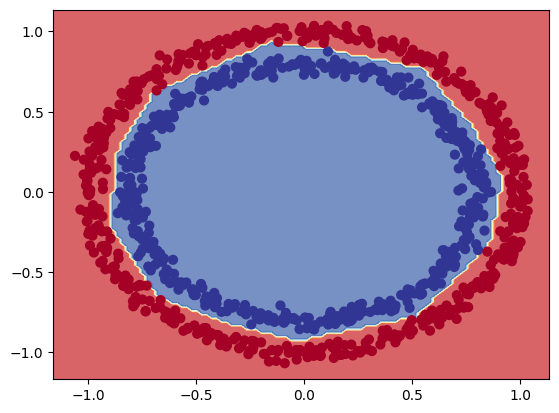

In [78]:
plot_decision_boundary(model_3,X,Y)

## 7. Replicating non-linear activation functions

Neural networks, rather than telling the model what to learn we give it the tools to learn and it figures out the best patterns on its own.

And these tools are linear and non-linear functions.

In [81]:
# Create a tensor

A = torch.arange(-10,10,1,dtype=torch.float32)
A.dtype

torch.float32

In [ ]:
plt.plot(torch.relu(A))

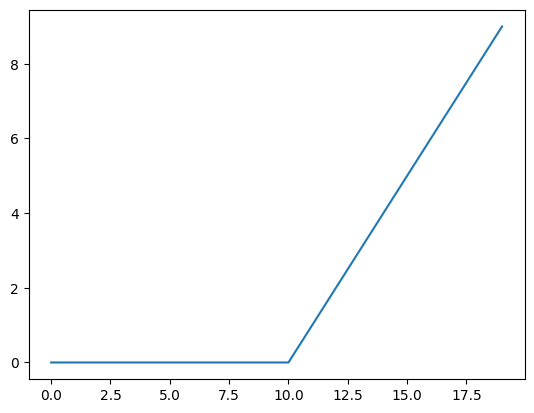

In [89]:
# Custom ReLU activation function

def relu(x):
  return torch.max(torch.tensor(0),x)

plt.plot(relu(A))

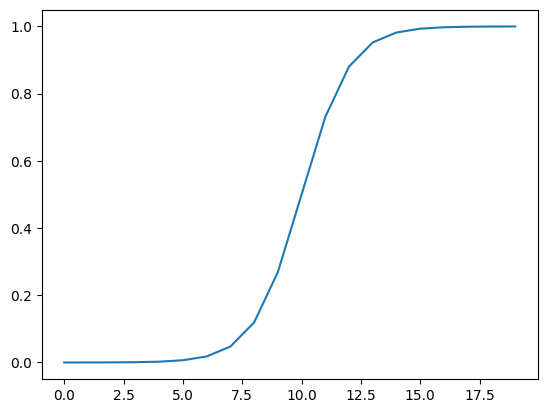

In [90]:
import math
def sigmoid(x):
  return 1/(1+torch.exp(-x))

plt.plot(sigmoid(A))

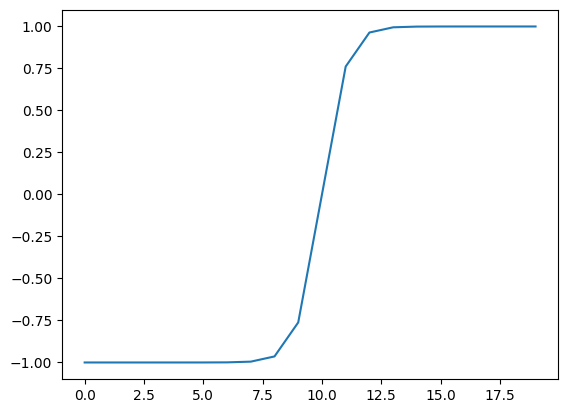

In [91]:
def tanh(x):
  return torch.tanh(x)

plt.plot(tanh(A))

##8. Putting it Altogether with a multi-class classification problem

* Binary classification = one thing or another e.g. spam vs not spam
* Mult-class classification = more than one thing or another e.g. cat vs dog vs fish

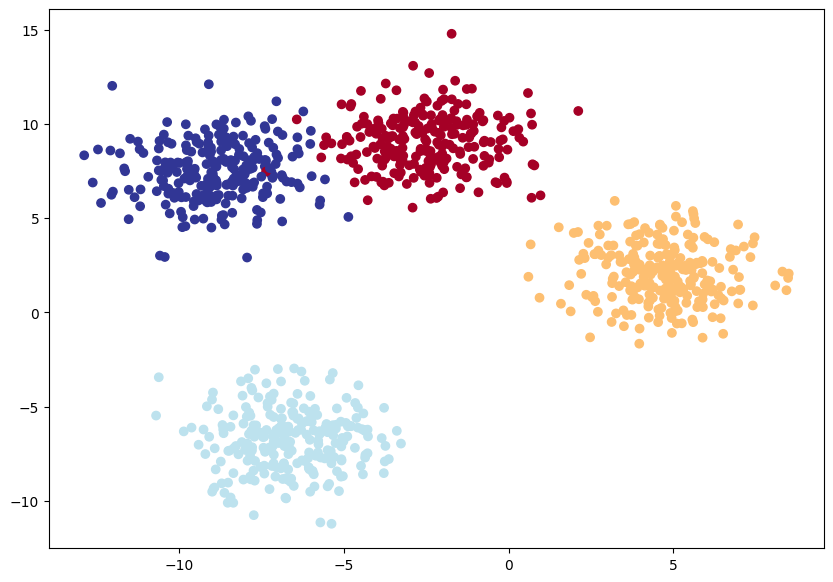

In [102]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#Set the Hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#1. Create multi-class data

X_blob,Y_blob = make_blobs(n_samples = 1000,
                           n_features = NUM_FEATURES,
                           centers = NUM_CLASSES,
                           cluster_std = 1.5,    # give the cluster a bit of randomness
                           random_state = RANDOM_SEED)
# Convert data to tensors

X_blob = torch.from_numpy(X_blob).type(torch.float)
Y_blob = torch.from_numpy(Y_blob).type(torch.float)

# 3. Train/test split

X_blob_train,X_blob_test,Y_blob_train,Y_blob_test = train_test_split(X_blob,Y_blob,test_size =0.2,random_state = RANDOM_SEED)

len(X_blob_train), len(Y_blob_test)

# 4. Plot data

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=Y_blob, cmap=plt.cm.RdYlBu)



### 8.2 building a multi-class classification model in PyTorch

In [104]:
# Device agnostic

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [163]:
# Build a multi-class classification model

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    """Initialises multi-class classification model.

    Args:
        input_features (int): number of input features to the model
        output_features (int): number of output classes of the model
        hidden_units (int): number of units in hidden layers (default = 8)

    Returns:

    Example:

    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

In [164]:
model_4 = BlobModel(input_features = NUM_FEATURES,
                    output_features = NUM_CLASSES,
                    hidden_units = 8)
model_4.to(device)

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimiser for a multi-class classification model

> Indented block



In [165]:
# Creat a loss function for multi=class classification

loss_fn = nn.CrossEntropyLoss()

#Create an optimiser for multi-class classification

optimiser = torch.optim.SGD(params = model_4.parameters(),
                            lr = 0.05)

In [166]:
Y_logits = model_4(X_blob_train).squeeze()
Y_preds_probs = torch.softmax(Y_logits,dim=1)


In [167]:
# Convert our models prediction probabilities to prediction labels

Y_preds = torch.argmax(Y_preds_probs, dim=1)
Y_preds[:10], Y_blob_train[:10]

(tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1., 0., 2., 2., 0., 0., 0., 1., 3., 0.]))

In [168]:
# Train and eval

epochs = 1000
torch.manual_seed(42)
X_blob_train,X_blob_test = X_blob_train.to(device),X_blob_test.to(device)
Y_blob_train,Y_blob_test = Y_blob_train.to(device),Y_blob_test.to(device)

for epoch in range (epochs):
  model_4.train()
  #1. Eval
  Y_logits = model_4(X_blob_train)
  Y_preds = torch.softmax(Y_logits,dim=1).argmax(dim=1)

  #2. Loss
  loss = loss_fn(Y_logits,Y_blob_train.type(torch.LongTensor))
  acc = accuracy_fn(y_true=Y_blob_train, y_pred = Y_preds)
  #3. Zero grad
  optimiser.zero_grad()
  #4. Backpropagation
  loss.backward()
  #5. Optimiser step
  optimiser.step()
  #6. Evaluation
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test.squeeze())
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)

    #2. Loss
    test_loss = loss_fn(test_logits,Y_blob_test.type(torch.LongTensor))
    test_acc = accuracy_fn(y_true=Y_blob_test, y_pred = test_preds)
  if epoch %100 == 0:
      print(f"epoch: {epoch}, Loss: {loss}, acc: {acc}, Test loss: {test_loss}, test acc: {test_acc}")


epoch: 0, Loss: 1.1588267087936401, acc: 40.375, Test loss: 1.1147195100784302, test acc: 46.0
epoch: 100, Loss: 0.06543432176113129, acc: 99.25, Test loss: 0.05884408578276634, test acc: 99.5
epoch: 200, Loss: 0.0331401564180851, acc: 99.25, Test loss: 0.024451429024338722, test acc: 99.5
epoch: 300, Loss: 0.028353311121463776, acc: 99.25, Test loss: 0.01877751760184765, test acc: 99.5
epoch: 400, Loss: 0.026584913954138756, acc: 99.25, Test loss: 0.016545794904232025, test acc: 99.5
epoch: 500, Loss: 0.02563817799091339, acc: 99.25, Test loss: 0.015261202119290829, test acc: 99.5
epoch: 600, Loss: 0.025038383901119232, acc: 99.25, Test loss: 0.014415374025702477, test acc: 99.5
epoch: 700, Loss: 0.024612070992588997, acc: 99.25, Test loss: 0.013809269294142723, test acc: 99.5
epoch: 800, Loss: 0.02428198605775833, acc: 99.25, Test loss: 0.013362365774810314, test acc: 99.5
epoch: 900, Loss: 0.024010632187128067, acc: 99.25, Test loss: 0.01301365252584219, test acc: 99.5


In [ ]:
plot_decision_boundary(model_4,X_blob,Y_blob)

## 9. A few more classification metrics to evaluate model performance

* Accuracy
* Precision
* Recall
* F1- score
* Confusion matric
* Classification report

In [171]:
!pip install torchmetrics
import torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.8 MB/s eta 0:00:00


In [175]:
# Setup metric

torchMetricAcc  = torchmetrics.Accuracy(task="multiclass",num_classes=4).to(device)
torchMetricAcc(test_preds,Y_blob_test)

tensor(0.9950)